In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Simulate quickdraw_labels with 340 sample labels
quickdraw_labels = {i: f"Label {i}" for i in range(340)}

class ProficiencySystem:
    def __init__(self):
        # Precomputed difficulty tiers (modify as needed)
        self.difficulty_tiers = self._create_difficulty_tiers()
        
        # RL Model to predict proficiency updates
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='mse')
        
        # User state storage
        self.user_states = {}
        
        # Performance metrics
        self.performance_history = {
            'training_loss': [],
            'user_progression': [],
            'word_effectiveness': {i: [] for i in range(340)}
        }

    def _create_difficulty_tiers(self):
        """Create difficulty tiers based on empirical data (modify as needed)"""
        return {
            'easy': list(range(0, 113)),    # Simple shapes/common objects
            'medium': list(range(113, 227)),# Moderate complexity
            'hard': list(range(227, 340))   # Complex items/abstract concepts
        }

    def _get_initial_proficiency(self):
        """Bayesian average for new users"""
        return 0.4  # Conservative starting point

    def update_proficiency(self, user_id: str, success: bool, 
                           time_taken: float, confidence: float) -> float:
        """Update and return new proficiency score (0-1 scale)"""
        if user_id not in self.user_states:
            self.user_states[user_id] = {
                'proficiency': self._get_initial_proficiency(),
                'recent': deque(maxlen=5)  # Last 5 attempts
            }
            
        user = self.user_states[user_id]
        time_factor = 1 - min(time_taken, 60) / 60  # Normalize to 0-1
        
        # Create input features
        features = np.array([
            user['proficiency'],
            float(success),
            time_factor * confidence if success else (1 - confidence)
        ])
        
        # Calculate target update
        target = user['proficiency'] + 0.1 * ((2 * success - 1) * confidence * time_factor)
        target = np.clip(target, 0, 1)
        
        # Train model incrementally on a single batch
        loss = self.model.train_on_batch(
            features.reshape(1, -1), 
            np.array([target])
        )
        
        # Update state and track metrics
        user['proficiency'] = float(target)
        user['recent'].append((success, time_factor, confidence))
        self.performance_history['training_loss'].append(loss)
        
        # (Optional) For simulation purposes, update a random word's effectiveness.
        # In a real system, this might reflect the performance on the drawn prompt.
        random_word = np.random.choice(self.difficulty_tiers['easy'] + 
                                       self.difficulty_tiers['medium'] + 
                                       self.difficulty_tiers['hard'])
        self.performance_history['word_effectiveness'][random_word].append(1.0 if success else 0.0)
        
        return user['proficiency']

    def get_word(self, user_id: str) -> dict:
        """Get an appropriate word for the user's current level"""
        proficiency = self.user_states.get(user_id, {}).get('proficiency', 0.4)
        
        # Dynamic difficulty selection
        if proficiency < 0.4:
            tier = 'easy'
        elif proficiency < 0.7:
            tier = 'medium'
        else:
            tier = 'hard'
            
        # Select the word with the lowest historical success rate in the tier
        word_id = min(self.difficulty_tiers[tier], 
                      key=lambda x: np.mean(self.performance_history['word_effectiveness'][x]) 
                                   if self.performance_history['word_effectiveness'][x] else 0)
        
        return {'word_id': word_id, 'word': quickdraw_labels[word_id]}

    def assess_performance(self):
        """Calculate key performance metrics"""
        return {
            'avg_training_loss': np.mean(self.performance_history['training_loss'][-100:]) 
                                 if self.performance_history['training_loss'] else None,
            'user_progression': np.mean([u['proficiency'] for u in self.user_states.values()]) 
                                if self.user_states else None,
            'word_effectiveness': {
                word: np.mean(scores) 
                for word, scores in self.performance_history['word_effectiveness'].items()
                if scores
            }
        }

    def save_model(self, path: str):
        self.model.save(path)
    
    def load_model(self, path: str):
        self.model = tf.keras.models.load_model(path)


In [2]:
# Create an instance of the proficiency system
ps = ProficiencySystem()

# Simulate 10 users
user_ids = [f"user_{i}" for i in range(10)]
import random

# Simulate 100 attempts per user with random performance metrics
for _ in range(100):
    for user in user_ids:
        success = random.choice([True, False])
        time_taken = random.uniform(5, 60)  # Time between 5 and 60 seconds
        # Use higher confidence if successful, lower if not
        confidence = random.uniform(0.5, 1.0) if success else random.uniform(0, 0.5)
        ps.update_proficiency(user, success, time_taken, confidence)


c:\Users\ASUS\anaconda35\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


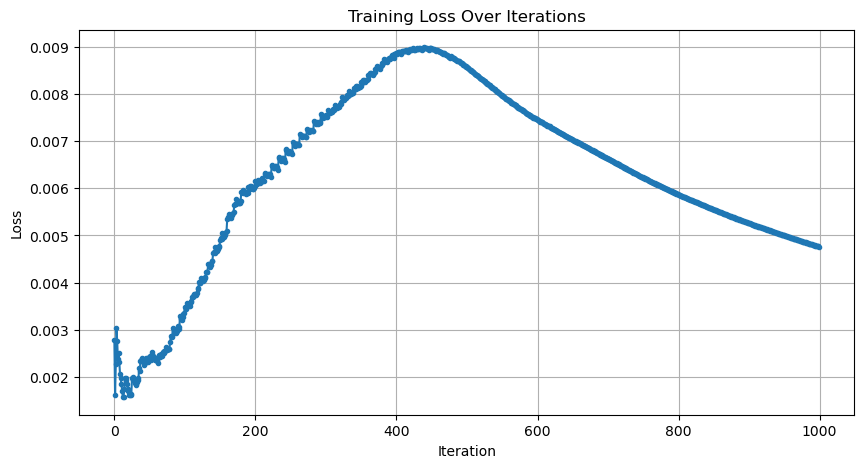

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(ps.performance_history['training_loss'], marker='o', linestyle='-', markersize=3)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


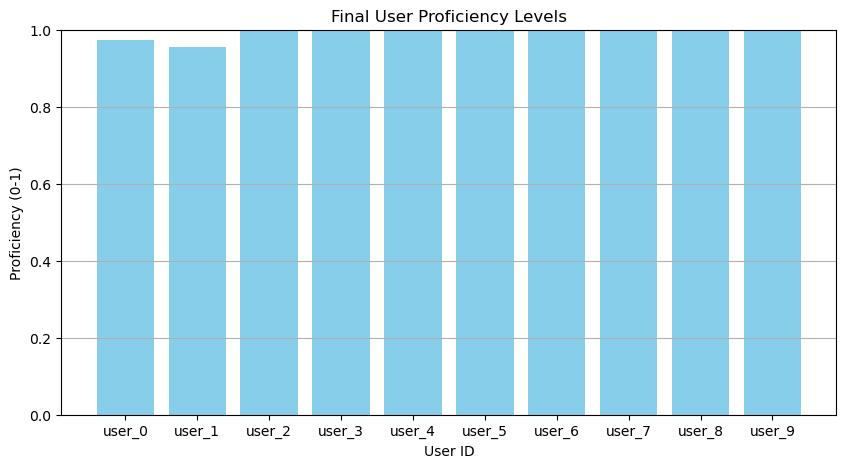

In [4]:
# Extract final proficiency for each user
user_proficiencies = [ps.user_states[user]['proficiency'] for user in user_ids]

plt.figure(figsize=(10, 5))
plt.bar(user_ids, user_proficiencies, color='skyblue')
plt.title("Final User Proficiency Levels")
plt.xlabel("User ID")
plt.ylabel("Proficiency (0-1)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


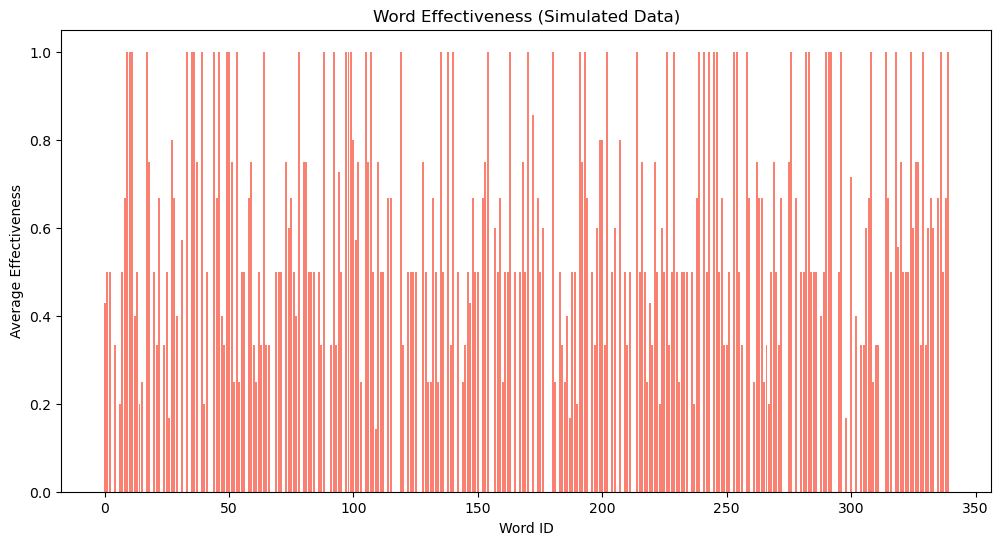

In [5]:
# Calculate average effectiveness for words that have data
word_ids = []
effectiveness = []
for word, scores in ps.performance_history['word_effectiveness'].items():
    if scores:  # Only consider words that have been updated
        word_ids.append(word)
        effectiveness.append(np.mean(scores))

plt.figure(figsize=(12, 6))
plt.bar(word_ids, effectiveness, color='salmon')
plt.title("Word Effectiveness (Simulated Data)")
plt.xlabel("Word ID")
plt.ylabel("Average Effectiveness")
plt.show()


In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import deque

# Initialize Flask app
app = Flask(__name__)

# Load CSV file for difficulty ranking.
# The CSV should have columns: "label", "composite_score", "difficulty_level"
words_df = pd.read_csv('difficulty_ranking.csv')

class ProficiencySystem:
    def __init__(self, words_df):
        self.words_df = words_df

        # Store performance metrics (expand as needed)
        self.performance_history = {
            'training_loss': [],
            'user_progression': []
        }

        # Dictionary to store per-user state
        self.user_states = {}

        # Define the RL model using an explicit Input layer to avoid warnings.
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(3,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='mse')

    def _get_initial_proficiency(self):
        """Bayesian average for new users (conservative starting point)"""
        return 0.4

    def update_proficiency(self, user_id, success, time_taken, confidence):
        """Update and return the new proficiency score (0-1 scale) for a user."""
        if user_id not in self.user_states:
            self.user_states[user_id] = {
                'proficiency': self._get_initial_proficiency(),
                'recent': deque(maxlen=5)
            }
        user = self.user_states[user_id]
        time_factor = 1 - min(time_taken, 60) / 60  # Normalize time (clipped at 60s)

        # Build input features: current proficiency, success flag, and a confidence/time factor.
        features = np.array([
            user['proficiency'],
            float(success),
            time_factor * confidence if success else (1 - confidence)
        ])

        # Calculate a target update for proficiency:
        target = user['proficiency'] + 0.1 * ((2 * success - 1) * confidence * time_factor)
        target = np.clip(target, 0, 1)

        # Train model incrementally on this single sample.
        loss = self.model.train_on_batch(features.reshape(1, -1), np.array([target]))

        # Update state and record training loss.
        user['proficiency'] = float(target)
        user['recent'].append((success, time_factor, confidence))
        self.performance_history['training_loss'].append(loss)

        return user['proficiency']

    def get_word(self, user_id):
        """Select an appropriate word for the user based on their proficiency."""
        # Retrieve user proficiency; if not found, default to the initial value.
        proficiency = self.user_states.get(user_id, {}).get('proficiency', self._get_initial_proficiency())

        # Map proficiency (0-1) to a difficulty level (1-5).
        # For example, proficiency=0 maps to level 1; proficiency=1 maps to level 5.
        target_level = int(np.clip(round(1 + proficiency * 4), 1, 5))

        # Filter the CSV to include words that match the target difficulty level.
        filtered = self.words_df[self.words_df['difficulty_level'] == target_level]
        if filtered.empty:
            return {"error": "No words available for the target difficulty."}

        # Choose one word at random from the filtered rows.
        chosen_label = filtered.sample(1).iloc[0]['label']
        return {"label": chosen_label, "target_level": target_level}

# Create a global instance of the ProficiencySystem.
ps = ProficiencySystem(words_df)

# Endpoint to update proficiency.
@app.route('/update_proficiency', methods=['POST'])
def update_proficiency_endpoint():
    data = request.get_json()
    # Expect JSON with keys: user_id, success, time_taken, confidence
    user_id = data.get('user_id')
    success = data.get('success')
    time_taken = data.get('time_taken')
    confidence = data.get('confidence')

    if user_id is None or success is None or time_taken is None or confidence is None:
        return jsonify({"error": "Missing required parameters."}), 400

    new_proficiency = ps.update_proficiency(user_id, success, time_taken, confidence)
    return jsonify({"user_id": user_id, "new_proficiency": new_proficiency})

# Endpoint to get the best word.
@app.route('/get_word', methods=['GET'])
def get_word_endpoint():
    user_id = request.args.get('user_id')
    if not user_id:
        return jsonify({"error": "Missing user_id parameter."}), 400
    result = ps.get_word(user_id)
    return jsonify(result)

# A simple simulation function to mimic more realistic user behavior.
def simulate_user(user_id, attempts=20):
    import random
    for _ in range(attempts):
        # Simulate a realistic pattern:
        # A user might have more failures initially and then improve.
        success_probability = 0.4 + 0.03 * _
        success = random.random() < success_probability
        time_taken = random.uniform(10, 60)  # realistic drawing times
        # Confidence might start lower and increase with success.
        confidence = random.uniform(0.4, 0.8) if success else random.uniform(0.0, 0.5)
        new_prof = ps.update_proficiency(user_id, success, time_taken, confidence)
        print(f"Attempt {_+1}: Success={success}, Time={time_taken:.1f}, Confidence={confidence:.2f} -> Proficiency={new_prof:.3f}")

if __name__ == '__main__':
    # Uncomment the following lines to simulate user behavior before starting the server.
    # simulate_user("simulated_user", attempts=30)
    
    app.run(port=5005, debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5005
Press CTRL+C to quit
127.0.0.1 - - [15/Feb/2025 07:49:35] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:54:23] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:54:56] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:55:00] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:55:03] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:56:21] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:57:43] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 07:58:06] "GET /get_word?user_id=d8b89d4b-7b77-499f-926a-72238f1b6ac1 HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 08:04:19] "G